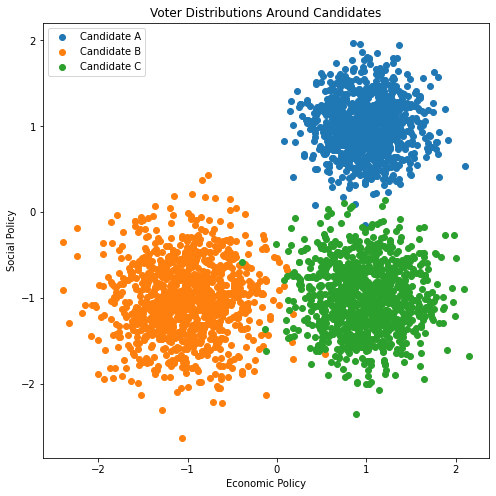

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the candidates
candidates = {
    'Candidate A': {'mean': [1, 1], 'cov': [[0.1, 0], [0, 0.1]]},
    'Candidate B': {'mean': [-1, -1], 'cov': [[0.2, 0], [0, 0.2]]},
    'Candidate C': {'mean': [1, -1], 'cov': [[0.15, 0], [0, 0.15]]},
}

# Generate voter distributions
voters = []
labels = []
for candidate, properties in candidates.items():
    distribution = np.random.multivariate_normal(properties['mean'], properties['cov'], 1000)
    voters.append(distribution)
    labels.extend([candidate]*len(distribution))

voters = np.concatenate(voters)

# Plot the distributions
plt.figure(figsize=(8, 8))
for candidate, properties in candidates.items():
    plt.scatter(*voters[np.array(labels) == candidate].T, label=candidate)
plt.legend()
plt.xlabel('Economic Policy')
plt.ylabel('Social Policy')
plt.title('Voter Distributions Around Candidates')
plt.show()

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numba import njit

from sklearn.manifold import MDS
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder


@njit
def calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks):
    mentioned_together = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks):
            for k in range(num_ranks):
                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together


def perform_rcv_analysis(csv_file, ignore_values=None, metric=False):
    if ignore_values is None:
        ignore_values = ['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote']

    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    candidate_names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    label_encoder = LabelEncoder()
    label_encoder.fit(candidate_names)
    ballots = [label_encoder.transform(ballot) for ballot in raw_ballots]
    candidate_names = label_encoder.classes_
    num_candidates = len(candidate_names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    num_ballots, num_ranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute 'd' (distance metric)
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Perform nonmetric MDS for 1 dimension
    mds = MDS(n_components=1, metric=metric, max_iter=1000, dissimilarity='precomputed')
    y_values_1d = mds.fit_transform(distance)

    # Identify common order in 1D
    order_1d = np.argsort(y_values_1d.flatten())

    # Calculate pairwise distances in 1D
    pairwise_distances_1d = distance_matrix(y_values_1d, y_values_1d)

    # Store distances and order in dictionary
    distance_dict = {}
    distance_dict["1D"] = {}
    distance_dict["1D"]["order"] = candidate_names[order_1d]
    distance_dict["1D"]["distances"] = pairwise_distances_1d

    # Plot 1D
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(y_values_1d), y_values_1d)
    for i in range(num_candidates):
        plt.text(0.2, y_values_1d[i], candidate_names[i])
    plt.axis([-1, 1.5, y_values_1d.min()*1.2, y_values_1d.max()*1.2])
    plt.show()

    # Perform nonmetric MDS for 2 dimensions
    mds = MDS(n_components=2, metric=metric, max_iter=1000, dissimilarity='precomputed')
    y_values_2d = mds.fit_transform(distance)

    # Identify common order in 2D
    order_2d = np.lexsort(y_values_2d.T)

    # Calculate pairwise distances in 2D
    pairwise_distances_2d = distance_matrix(y_values_2d, y_values_2d)

    # Store distances and order in dictionary
    distance_dict["2D"] = {}
    distance_dict["2D"]["order"] = candidate_names[order_2d]
    distance_dict["2D"]["distances"] = pairwise_distances_2d

    # Plot 2D
    plt.figure(figsize=(10, 6))
    plt.scatter(y_values_2d[:, 0], y_values_2d[:, 1])
    for i in range(num_candidates):
        plt.text(y_values_2d[i, 0], y_values_2d[i, 1], candidate_names[i])
    plt.grid(True)
    plt.show()

    return distance_dict

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from numba import njit
from collections import Counter, defaultdict

from scipy.spatial import distance_matrix
from sklearn.utils import check_random_state
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder


@njit
def calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks):
    mentioned_together = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks):
            for k in range(num_ranks):
                if ballots[i, j] <= num_candidates and ballots[i, k] <= num_candidates:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together


def perform_rcv_analysis(csv_file, n_runs, random_state=None, ignore_values=None, metric=True):
    if ignore_values is None:
        ignore_values = ['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote']

    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    candidate_names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    label_encoder = LabelEncoder()
    label_encoder.fit(candidate_names)
    ballots = [label_encoder.transform(ballot) for ballot in raw_ballots]
    candidate_names = label_encoder.classes_
    num_candidates = len(candidate_names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    num_ballots, num_ranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((num_candidates, num_candidates))
    for i in range(num_ballots):
        for j in range(num_ranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, num_candidates, num_ballots, num_ranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    frequencies = counts / mentioned_together

    # Combine frequencies in either direction to create symmetric matrix
    freq_upper_triangle = np.zeros((num_candidates, num_candidates))
    for i in range(num_candidates):
        for j in range(i+1, num_candidates):
            freq_upper_triangle[i, j] = (frequencies[i, j] + frequencies[j, i]) / 2
            freq_upper_triangle[j, i] = freq_upper_triangle[i, j]

    # Compute 'd' (distance metric)
    min_freq = np.min(freq_upper_triangle[freq_upper_triangle > 0])
    distance = 1 / np.sqrt(freq_upper_triangle)
    distance[np.isnan(distance)] = 2 / min_freq
    distance[np.isinf(distance)] = 2 / min_freq
    np.fill_diagonal(distance, 0)

    # Initialize random state
    random_state = check_random_state(random_state)

    # Run MDS multiple times
    all_orders = []
    all_y_values = defaultdict(list)
    all_pairwise_distances = []
    for i in range(n_runs):

        # Perform nonmetric MDS for 1 dimension
        mds = MDS(n_components=1, metric=metric, max_iter=1000, random_state=random_state, dissimilarity='precomputed', normalized_stress='auto')
        y_values_1d = mds.fit_transform(distance)

        # Identify order in 1D
        order_1d = np.argsort(y_values_1d.flatten())
        print(order_1d)
        print(y_values_1d)

        # Calculate pairwise distances in 1D
        pairwise_distances_1d = distance_matrix(y_values_1d, y_values_1d)

        # Store distances and order
        all_orders.append(tuple(order_1d))
        all_y_values[tuple(order_1d)].append(y_values_1d)
        all_pairwise_distances.append(pairwise_distances_1d)

    # Find most common order and frequencies of all orders
    order_counter = Counter(all_orders)
    most_common_order = order_counter.most_common(1)[0][0]
    all_order_frequencies = order_counter.most_common()

    # Calculate average pairwise distances for most common order
    most_common_order_indices = [i for i, order in enumerate(all_orders) if order == most_common_order]
    avg_pairwise_distances = np.mean([all_pairwise_distances[i] for i in most_common_order_indices], axis=0)

    # Calculate average MDS coordinates for most common order
    avg_y_values = np.mean(all_y_values[most_common_order], axis=0)
    print(order_counter)
    print(candidate_names)
    print(most_common_order)
    print(avg_y_values)

    # Plot average MDS coordinates for most common order
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(avg_y_values), avg_y_values)
    for i in range(num_candidates):
        plt.text(0.2, avg_y_values[i], candidate_names[most_common_order[i]])
    plt.axis([-1, 1.5, avg_y_values.min()*1.2, avg_y_values.max()*1.2])
    plt.show()

    # Plot frequencies of all orders
    plt.figure(figsize=(10, 6))
    orders, frequencies = zip(*all_order_frequencies)
    orders = ["-".join(candidate_names[list(order)]) for order in orders]
    plt.barh(orders, frequencies)
    plt.xlabel("Frequency")
    plt.title("Frequencies of Candidate Orders")
    plt.show()

    return avg_pairwise_distances, most_common_order

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_76908/1758569411.py:79: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


[1 0 3 2]
[[-0.72535797]
 [-1.76303809]
 [ 1.6458418 ]
 [ 0.84255426]]
[1 0 2 3]
[[-0.72535797]
 [-1.76303809]
 [ 0.51157837]
 [ 1.97681769]]
[1 0 2 3]
[[-0.72535797]
 [-1.76303809]
 [ 0.51157837]
 [ 1.97681769]]
[2 3 0 1]
[[ 0.72535797]
 [ 1.76303809]
 [-1.6458418 ]
 [-0.84255426]]
[0 1 2 3]
[[-1.68830798]
 [-0.80008808]
 [ 0.51157837]
 [ 1.97681769]]
[3 0 2 1]
[[-0.25580454]
 [ 1.76303809]
 [ 0.46958413]
 [-1.97681769]]
[1 2 0 3]
[[ 0.25580454]
 [-1.76303809]
 [-0.46958413]
 [ 1.97681769]]
[0 1 2 3]
[[-1.68830798]
 [-0.80008808]
 [ 0.51157837]
 [ 1.97681769]]
[1 0 2 3]
[[-0.72535797]
 [-1.76303809]
 [ 0.51157837]
 [ 1.97681769]]
[1 2 0 3]
[[ 0.25580454]
 [-1.76303809]
 [-0.46958413]
 [ 1.97681769]]
[3 0 1 2]
[[-0.25580454]
 [ 0.58678043]
 [ 1.6458418 ]
 [-1.97681769]]
[3 2 0 1]
[[ 0.72535797]
 [ 1.76303809]
 [-0.51157837]
 [-1.97681769]]
[0 1 2 3]
[[-1.68830798]
 [-0.80008808]
 [ 0.51157837]
 [ 1.97681769]]
[3 2 1 0]
[[ 1.68830798]
 [ 0.80008808]
 [-0.51157837]
 [-1.97681769]]
[1 0 2

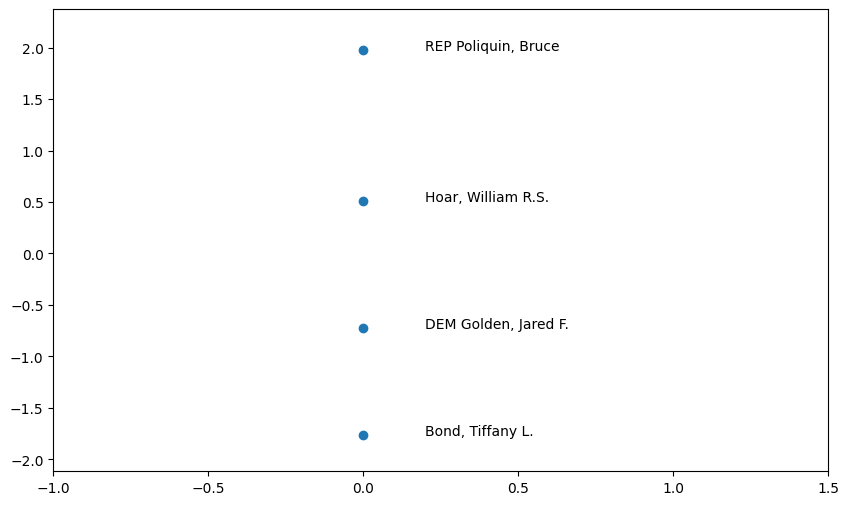

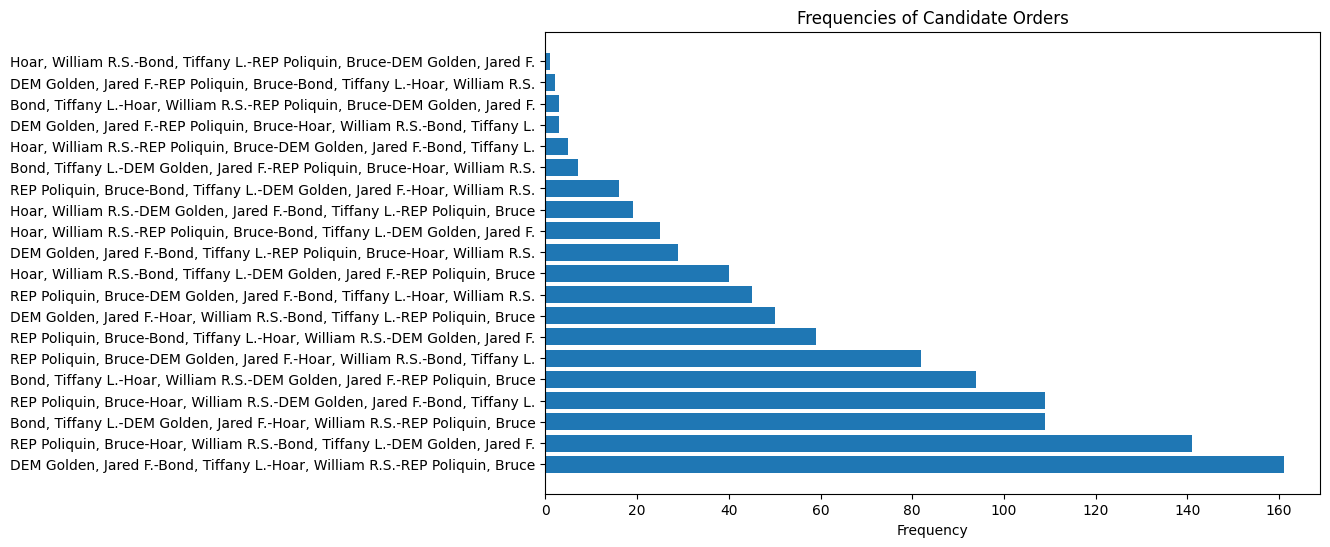

(array([[0.        , 1.03768012, 1.23693634, 2.70217566],
       [1.03768012, 0.        , 2.27461646, 3.73985578],
       [1.23693634, 2.27461646, 0.        , 1.46523932],
       [2.70217566, 3.73985578, 1.46523932, 0.        ]]), (1, 0, 2, 3))


In [44]:
# Test the function with the provided CSV file
maine = perform_rcv_analysis(f"Maine_11062018_CongressionalDistrict2.csv", n_runs=1000)
print(maine)

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_76908/865226325.py:79: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Counter({(1, 2, 0, 3): 14, (3, 2, 0, 1): 13, (1, 0, 2, 3): 13, (2, 1, 0, 3): 10, (3, 0, 1, 2): 10, (3, 0, 2, 1): 9, (3, 1, 0, 2): 8, (2, 0, 1, 3): 6, (3, 2, 1, 0): 6, (0, 3, 2, 1): 4, (0, 1, 2, 3): 3, (2, 3, 0, 1): 2, (1, 2, 3, 0): 2})
['Begich, Nick' 'Bye, Chris' 'Palin, Sarah' 'Peltola, Mary S.']
(1, 2, 0, 3)
[[ 0.2902431 ]
 [-2.1343301 ]
 [-0.4034257 ]
 [ 2.24751271]]


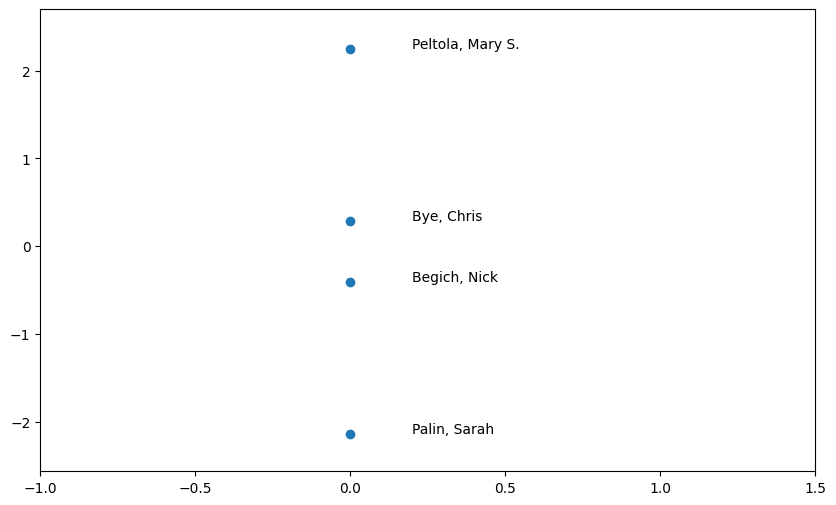

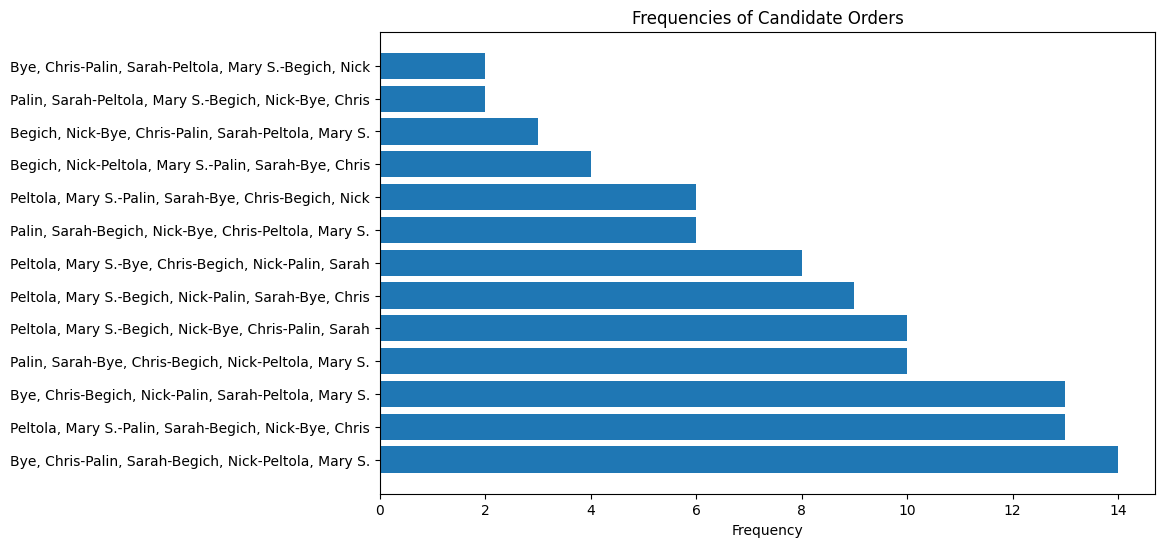

(array([[0.        , 2.4245732 , 0.6936688 , 1.95726962],
       [2.4245732 , 0.        , 1.7309044 , 4.38184281],
       [0.6936688 , 1.7309044 , 0.        , 2.65093841],
       [1.95726962, 4.38184281, 2.65093841, 0.        ]]), (1, 2, 0, 3))


In [40]:
# Test the function with the provided CSV file
alaska = perform_rcv_analysis(f"Alaska_11082022_USRepresentative.csv", n_runs=100)
print(alaska)

/Users/es5891/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/es5891/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/es5891/Library/Python/3.9/lib/python/site-packages/umap/distances.py:1086: 

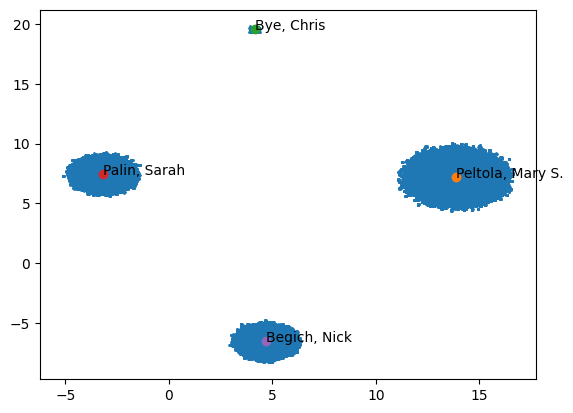

In [5]:
import umap
from sklearn.preprocessing import OneHotEncoder

# Load the CSV file
df = pd.read_csv(f"Alaska_11082022_USRepresentative.csv")

# Filter out rows that do not have a candidate ranked first
ignore_values = ['skipped', 'overvote', 'writein','Write-in']
df = df[~df['rank1'].isin(ignore_values)]

# Create a list of all candidate names
candidate_names = pd.unique(df['rank1'])

# Perform one-hot encoding
encoder = OneHotEncoder(sparse=False, categories=[candidate_names])
ballots = encoder.fit_transform(df[['rank1']])

# Perform UMAP embedding
embedding = umap.UMAP().fit_transform(ballots)

# Plot the voting clusters
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)

# Calculate and plot the mean position of each candidate
for i, candidate in enumerate(candidate_names):
    mean_position = embedding[df['rank1'] == candidate].mean(axis=0)
    plt.scatter(mean_position[0], mean_position[1])
    plt.text(mean_position[0], mean_position[1], candidate)

plt.show()

In [7]:
from pyirt import irt

# Reshape your data to long format
# Each row should be a voter-candidate pair, with the voter ID, the candidate ID, and the rank
data_long = df.melt(id_vars='voter_id', var_name='candidate_id', value_name='rank')

# Fit the IRT model
item_param, user_param = irt(data_long['voter_id'], data_long['candidate_id'], data_long['rank'])

# Plot the estimated parameters
plt.scatter(user_param, [1]*len(user_param), label='Voters')
plt.scatter(item_param, [1]*len(item_param), label='Candidates')
plt.legend()
plt.show()

/Users/es5891/Library/Python/3.9/lib/python/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/es5891/Library/Python/3.9/lib/python/site-packages/pyirt/util/clib.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


KeyError: 'voter_id'